### Filtering the data according to the official USS operating hours:

**1. Time Ranges:**
   - Defined for regular, short (10 AM - 5 PM), long (10 AM - 8 PM), and extended (10 AM - 9 PM) hours.

**2. Month-Specific Conditions:**
   - A function `get_time_range_for_month()` is used to return the correct time range based on the month:
     - **October:** 10 AM - 5 PM
     - **November 1-3:** 10 AM - 5 PM
     - **December 1-15:** 10 AM - 8 PM
     - **December 16-31:** 10 AM - 9 PM
     - **Other months:** Use regular hours, 10 AM - 7 PM.

In [1]:
import pandas as pd

file_path = '/Users/liyuan/DSA3101/Analysis/combined_wait_time_df.csv'  
wait_time_df = pd.read_csv(file_path)

In [2]:
wait_time_df.head()

,datetime,year,month,day_of_week,date,time,hour,wait_time
0,2019-01-01 08:00:00+00:00,2019,1,1,2019-01-01,08:00:00,8,13.154467
1,2019-01-01 08:05:00+00:00,2019,1,1,2019-01-01,08:05:00,8,13.013864
2,2019-01-01 08:10:00+00:00,2019,1,1,2019-01-01,08:10:00,8,13.862746
3,2019-01-01 08:15:00+00:00,2019,1,1,2019-01-01,08:15:00,8,12.383340
4,2019-01-01 08:20:00+00:00,2019,1,1,2019-01-01,08:20:00,8,12.374923


In [3]:
# Adjust the datetime parsing by specifying the format for 'datetime' and 'time'
wait_time_df['datetime'] = pd.to_datetime(wait_time_df['datetime'], format='%Y-%m-%d %H:%M:%S%z')
wait_time_df['time'] = pd.to_datetime(wait_time_df['time'], format='%H:%M:%S').dt.time

In [4]:
# Define the time ranges for each type of day
time_ranges = {
    "regular": (pd.to_datetime('10:00:00').time(), pd.to_datetime('19:00:00').time()),
    "short": (pd.to_datetime('10:00:00').time(), pd.to_datetime('17:00:00').time()),
    "long": (pd.to_datetime('10:00:00').time(), pd.to_datetime('20:00:00').time()),
    "extended": (pd.to_datetime('10:00:00').time(), pd.to_datetime('21:00:00').time())
}

# Define the month-specific operating hours:
def get_time_range_for_month(month, day):
    if month == 12:
        # Special hours in December
        return time_ranges['long'] if 1 <= day <= 15 else time_ranges['extended']
    elif month == 10 or (month == 11 and day <= 3):
        # October 1 to October 31: 10 AM - 5 PM
        # November 1 - 3: 10 AM - 5 PM
        return time_ranges['short']
    else:
        # Regular days: 10 AM - 7 PM
        return time_ranges['regular']

In [5]:
# Filter the dataframe based on both time, month, and day
filtered_df = wait_time_df[
    wait_time_df.apply(
        lambda row: get_time_range_for_month(row['month'], row['day_of_week'])[0] <= row['time'] <= get_time_range_for_month(row['month'], row['day_of_week'])[1],
        axis=1
    )
]

In [9]:
# Save as csv file
# filtered_df.to_csv('filtered_combined_wait_time_df.csv', index=False)

### Create a new dataframe for average wait time for each day

In [7]:
# Create a new dataframe with just 'date' and the calculated average wait time for each day
daily_avg_wait_time_df = filtered_df.groupby('date')['wait_time'].mean().reset_index()

# Rename the column to 'avg_wait_time_day' 
daily_avg_wait_time_df.rename(columns={'wait_time': 'avg_wait_time_day'}, inplace=True)

# Round the 'avg_wait_time_day' to the nearest whole number
daily_avg_wait_time_df['avg_wait_time_day'] = daily_avg_wait_time_df['avg_wait_time_day'].round()

daily_avg_wait_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2028 non-null   object 
 1   avg_wait_time_day  2028 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.8+ KB


In [8]:
first_date = daily_avg_wait_time_df['date'].min()
last_date = daily_avg_wait_time_df['date'].max()

print("First Date:", first_date)
print("Last Date:", last_date)

First Date: 2019-01-01
Last Date: 2024-10-21


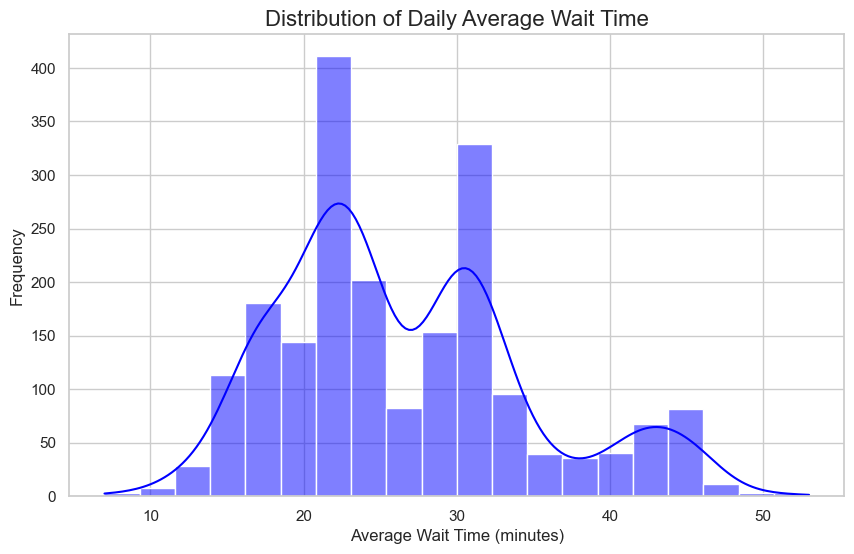

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Histogram to visualize the distribution of daily average wait time
plt.figure(figsize=(10, 6))
sns.histplot(daily_avg_wait_time_df['avg_wait_time_day'], bins=20, kde=True, color='blue')
plt.title('Distribution of Daily Average Wait Time', fontsize=16)
plt.xlabel('Average Wait Time (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [11]:
# Count the unique wait time values
unique_wait_times = daily_avg_wait_time_df['avg_wait_time_day'].value_counts().sort_index()

print(unique_wait_times)

avg_wait_time_day
7.0       2
8.0       1
10.0      6
11.0      2
12.0     12
13.0     16
14.0     20
15.0     37
16.0     56
17.0    100
18.0     80
19.0     58
20.0     86
21.0    135
22.0    134
23.0    142
24.0    122
25.0     80
26.0     53
27.0     29
28.0     61
29.0     92
30.0    116
31.0    114
32.0     99
33.0     59
34.0     36
35.0     21
36.0     18
37.0     14
38.0      4
39.0     18
40.0     17
41.0     23
42.0     35
43.0     32
44.0     29
45.0     26
46.0     26
47.0      7
48.0      4
49.0      3
51.0      2
53.0      1
Name: count, dtype: int64


### Classifying Wait Time Ratings Based on Average Wait Time per Day

#### 1. **Objective**:
   The goal is to classify the average wait times for attractions into ratings from **1 to 5**, where:
   - **Rating 1** should represent the longest wait times, indicating a poor experience.
   - **Rating 5** should represent the shortest wait times, indicating a great experience.

#### 2. **Classification Approach**:
   The average wait times (in minutes) for each day range from **7 minutes** to **53 minutes**. Based on this, the wait times are divided into the following specific ranges:


| **Wait Time (minutes)** | **Rating**  |
|-------------------------|-------------|
| 41 - 53                 | 1 (Longest) |
| 31 - 40                 | 2           |
| 21 - 30                 | 3           |
| 11 - 20                 | 4           |
| 7 - 10                  | 5 (Shortest)|

#### 3. **Rationale**:
   - This categorization helps to translate raw wait time data into actionable survey responses regarding visitor satisfaction with the wait times for different attractions. More specifically, to answer the question: **"How would you rate the wait time for the attractions you visited?"**

In [14]:
# Define the function to classify the wait times
def classify_wait_time(wait_time):
    if wait_time > 40:
        return 1  # Longest wait
    elif wait_time > 30:
        return 2
    elif wait_time > 20:
        return 3
    elif wait_time > 10:
        return 4
    else:
        return 5  # Shortest wait

# Apply the classification to the DataFrame
daily_avg_wait_time_df['wait_time_rating'] = daily_avg_wait_time_df['avg_wait_time_day'].apply(classify_wait_time)

In [18]:
daily_avg_wait_time_df.head()

,date,avg_wait_time_day,wait_time_rating
0,2019-01-01,29.0,3
1,2019-01-02,20.0,4
2,2019-01-03,21.0,3
3,2019-01-04,32.0,2
4,2019-01-05,31.0,2


In [19]:
# Save as csv file
daily_avg_wait_time_df.to_csv('daily_avg_wait_time_df.csv', index=False)